In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set(rc = {"figure.figsize":(16, 9)})

class OnlineData:

    def __init__(self, filename):
        self.filename = filename
        self.f = open(filename, 'r')
        self.TotalQ = 1
        self.Qnow = np.array([0])
        self.Pnow = np.array([0])
 
    def __next__(self):
        line = next(self.f)[:-1]
        if len(line) < 1:
            return None
        Q_, P_ = np.array([z[1:-1].split(",") for z in line.split("\t")
                          ]).astype(float).astype(int).T
        self.Qnow = Q_
        self.Pnow = P_
        CS = np.cumsum(P_ * np.ediff1d(Q_, to_begin=Q_[0]))

        self.TotalQ = sum(Q_)

        def F(Q):
            if Q <= Q_[0]:
                return P_[0] * Q
            if Q > Q_[-1]:
                return None
            i = np.searchsorted(Q_, Q)
            return CS[i - 1] + (Q - Q_[i - 1]) * P_[i]

        self.F = F
        return self.F

    def __iter__(self):
        return self

    def close(self):
        self.f.close()

In [33]:
def MIdQ(bidfilename: str,
               dQfilename: str,
               depth: int):
    
    it1 = OnlineData(bidfilename)
    it2 = OnlineData(bidfilename)

    Price2 = next(it2)
    Price1 = next(it1)
    Price2 = next(it2)

    dQ = open(dQfilename, 'w+')

    ans = list([np.arange(1000)])
    ansv = list([np.arange(len(ans))])


    for i in range(depth):
        if(i > 10):
            deltaP = (Price2(1) - Price1(1)) / Price1(1)
            volume = 0
            if not deltaP == None and deltaP > 0.0001:
                fluct = np.full((1000, ), 0)
                vols = np.full((999, ), 0)

                P2 = it2.Pnow
                P1 = it1.Pnow
                Q2 = it2.Qnow
                Q1 = it1.Qnow
                for k in range(len(P1)):
                    if(P1[k] != P2[1]):
                        volume += Q1[k]
                        # print(Q1[k])
                    if(P1[k] == P2[1]):
                        volume += (Q1[k] - Q2[1])
                        volume += Q2[0]
                        break

                vols[0] = volume
                fluct[0] = Price1(1)
                fluct[1] = Price2(1)

                for i in range(2, 1000):
                    volume = 0
                    Price2 = next(it2)
                    Price1 = next(it1)

                    P2 = it2.Pnow
                    P1 = it1.Pnow
                    Q2 = it2.Qnow
                    Q1 = it1.Qnow

                    fluct[i] = Price2(1)
                    if abs(fluct[i] - fluct[i - 1]) > 0 or True:
                        for k in range(len(P1)):
                            if(P1[k] != P2[1]):
                                volume += Q1[k]
                                # print(Q1[k])
                            if(P1[k] == P2[1]):
                                volume += (Q1[k] - Q2[1])
                                volume += Q2[0]
                                break
                        vols[i - 1] = volume
                    else:
                        vols[i - 1] = 0
                
                ans.append(fluct)
                ansv.append(vols)
                
        
        Price1 = next(it1)
        Price2 = next(it2)
        
    dQ.close()
    return ans, ansv

In [34]:
ans, ansv = MIdQ("DataForImpact/bid_22_10_03.tsv", "dQI.csv", 3000)

In [35]:
len(ans)

25

In [36]:
i = 2
plt.plot(ans[i])
# plt.plot(ansv[i])
plt.show()

In [7]:
plt.plot(ansv[i])

Text(0, 0.5, 'Объем ордера')

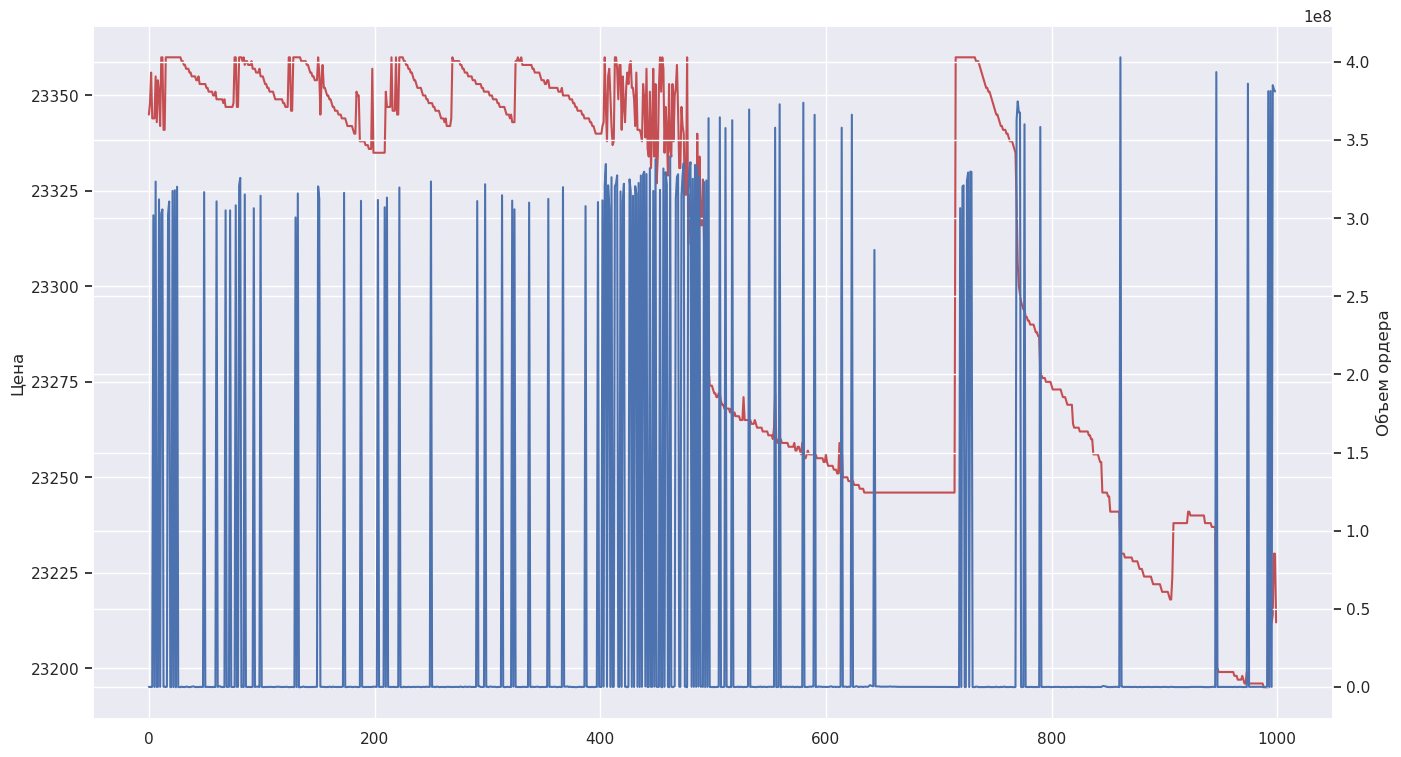

In [37]:
import matplotlib.pyplot as plt
import numpy as np

i = 15
x = np.linspace(0, 100)
a = x * 0.01
b = np.sqrt(x)
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(ans[i],color='r')
ax1.plot(ansv[i],color='b')
ax.set_ylabel('Цена')
ax1.set_ylabel('Объем ордера')

In [3]:
it1 = OnlineData("DataForImpact/bid_22_10_03.tsv")

prices = np.full((1000000,), 0)

for i in range(1000000):
    if(i > 100):
        Price = next(it1)
        prices[i] = it1.Pnow[0]

In [9]:
plt.plot(prices[1000:])